# Generating Sphere Packings from Digital Rocks Portal

The [digital rocks portal](https://www.digitalrocksportal.org) is a great resource for finding a variety of tomographic images. However, several of the items that can be found there are actually CSV files containing the coordinates and radii of spheres in a packing.  In this tutorial we'll look at a few of these and see how the ``spheres_from_coords`` function handles them.  

In [1]:
import porespy as ps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Finney Packing

The first one we'll look at is the [Finney Packing](https://www.digitalrocksportal.org/projects/47).  

To start with, we'll download the file and place it in the same directory as this notebook, which makes it easier to open.  We'll then use ``pandas`` to read the file, which always does an excellent job reading CSV files.

In [20]:
df = pd.read_csv('finney_packing.csv')
print(df)

        ID          X          Y          Z
0        1  -0.324554   0.081522  -0.452144
1        2   0.139446  -1.232478   0.985858
2        3   1.641446  -0.078478  -0.876144
3        4  -1.182554   0.557522   1.385856
4        5   1.713446   0.143522   1.107856
...    ...        ...        ...        ...
4016  4017   3.547448  11.858320  13.735856
4017  4018   5.597446   4.971524 -16.908144
4018  4019  -8.748554  16.023504   2.961856
4019  4020   7.353446 -16.964479  -0.500142
4020  4021 -13.228554   7.943524  10.203858

[4021 rows x 4 columns]


We can see that this file has coordinates for 4021 spheres in 3-dimensions, though no units are given.  It also does not include any information about the radii of the spheres.  In fact, Prof. Finney has left us the following challenge:

> *"With some effort, sphere locations can be used to produce a volumetric image at any resolution you need."*

Challenge accepted...

We'll start by assuming that the coordinates are in units of "sphere radii", so if we want spheres with a radii of 10 voxels, we need to (a) scale all the X, Y, and Z values by 10, and (b) insert a column into the DataFrame for "R", with all values equal to 10.

In [21]:
df['X'] *= 10
df['Y'] *= 10
df['Z'] *= 10
df['R'] = 10.0

In [22]:
im = ps.generators.spheres_from_coords(df)

Let's see how it looks using a couple of the quick visualization functions in PoreSpy:

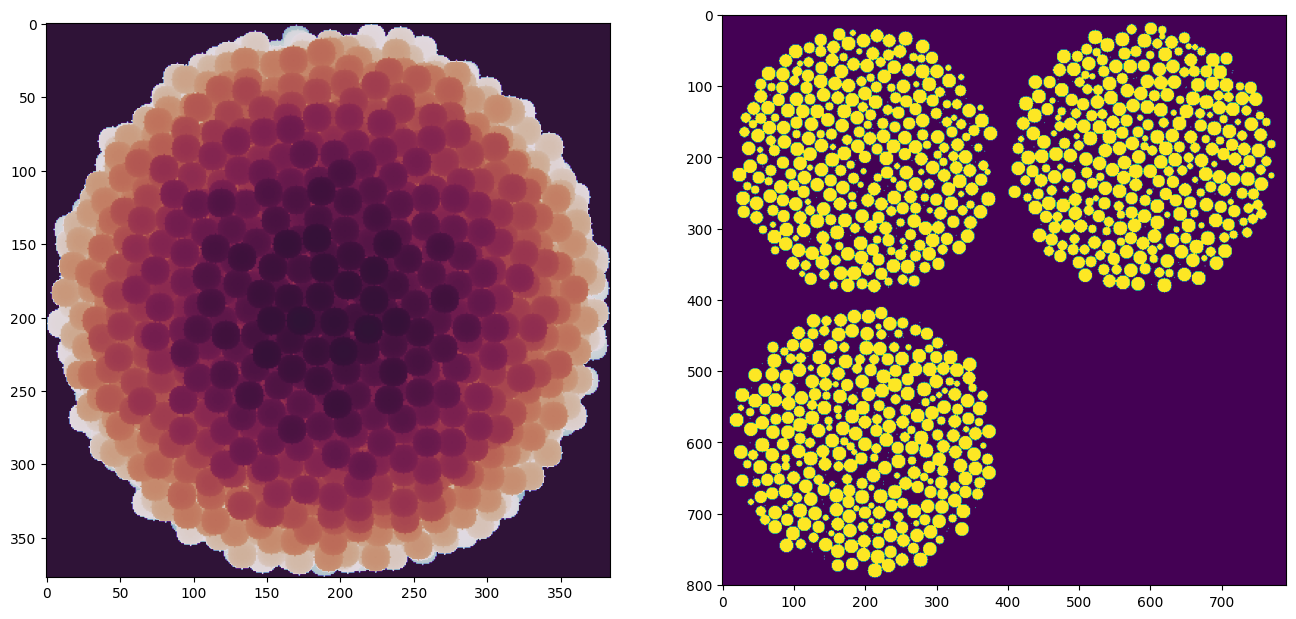

In [34]:
fig, ax = plt.subplots(1, 2, figsize=[16, 8])
ax[0].imshow(ps.visualization.sem(~im), cmap=plt.cm.twilight_shifted)
ax[1].imshow(ps.visualization.show_planes(im));

That was easy!  

*Justing kidding*, it took ages to write the ``spheres_from_coords`` function to handle all the edge cases, such as the negative numbers in the "finney_packing.csv" file.

## Bidisperse Sphere Packs

Next we'll look at the bidisperse sphere packs posted by [Bihani and Daigle](https://www.digitalrocksportal.org/projects/204).  This one is a bit more challenging because the spheres are different size, but the ``spheres_from_coords`` function should be able to handle this too:

In [6]:
df = pd.read_csv("5to1_VL49.9_2.csv")
print(df)

        3.0182  0.8832   9.5101  0.5
0      5.16800  7.4590  9.91010  0.1
1      3.52470  6.0797  9.91050  0.1
2      9.77820  9.9506  9.91000  0.1
3      3.66130  3.3672  9.91040  0.1
4      1.25630  3.7398  9.91020  0.1
...        ...     ...      ...  ...
78539  3.00070  9.0727  0.83122  0.1
78540  7.81650  8.9274  0.59451  0.1
78541  4.27500  6.6440  0.83542  0.1
78542  0.93797  1.4616  0.81609  0.1
78543  5.73430  3.9447  1.08350  0.1

[78544 rows x 4 columns]


The first thing to notice is that the CSV file was not formatted as expected, as it lacked a header row so took the first row of data as the header.  We can alter the ``read_csv`` function to account for this.  The docstring for this functin is *ridiculously* long, but that is the price to pay for such a flexible function.  After some digging we can learn that it's possible to not read a header from the file, and to supply our own column names:

In [7]:
df = pd.read_csv("5to1_VL49.9_2.csv", header=None, names=['X', 'Y', 'Z', 'R'])
print(df)

             X       Y        Z    R
0      3.01820  0.8832  9.51010  0.5
1      5.16800  7.4590  9.91010  0.1
2      3.52470  6.0797  9.91050  0.1
3      9.77820  9.9506  9.91000  0.1
4      3.66130  3.3672  9.91040  0.1
...        ...     ...      ...  ...
78540  3.00070  9.0727  0.83122  0.1
78541  7.81650  8.9274  0.59451  0.1
78542  4.27500  6.6440  0.83542  0.1
78543  0.93797  1.4616  0.81609  0.1
78544  5.73430  3.9447  1.08350  0.1

[78545 rows x 4 columns]


Like the previous packing, we need to scale the coordinates and radii. We don't want this file to become too large, so let's go with 25 voxels for the largest spheres and 5 voxels for the smaller ones.  This means scaling by 50x.

In [8]:
df['X'] *= 50
df['Y'] *= 50
df['Z'] *= 50
df['R'] *= 50

In [9]:
print(df)

              X        Y         Z     R
0      150.9100   44.160  475.5050  25.0
1      258.4000  372.950  495.5050   5.0
2      176.2350  303.985  495.5250   5.0
3      488.9100  497.530  495.5000   5.0
4      183.0650  168.360  495.5200   5.0
...         ...      ...       ...   ...
78540  150.0350  453.635   41.5610   5.0
78541  390.8250  446.370   29.7255   5.0
78542  213.7500  332.200   41.7710   5.0
78543   46.8985   73.080   40.8045   5.0
78544  286.7150  197.235   54.1750   5.0

[78545 rows x 4 columns]


Before proceeding, let's estimate how large this image will be:

In [10]:
(df['X'].max()*df['Y'].max()*df['Z'].max())**0.333

495.4219546770277

A 500-cubed image is fairly manageble, but care should be taken not to get too aggressive with high resolutions.  Probably trial-and-error is the best approach, starting with small values and increasing until you're satisfied with result AND willing to wait the required time.  A 500-cubed image should only take 5-10 seconds, but this number grows quickly as the image size increase and the size of the spheres being inserted increases

In [11]:
im = ps.generators.spheres_from_coords(df)

This image is difficult to visualize in 2D due to the small spheres essentially filling much of the image.  The following is a fake x-ray attenuation image through the last 100 layers in the z-direction.  The large spheres and densely packed fines are both visible.

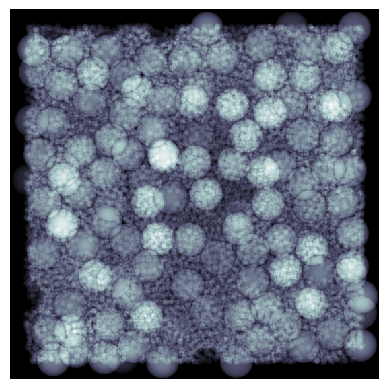

In [16]:
fig, ax = plt.subplots()
ax.imshow(ps.visualization.xray(~im[..., :100], axis=2), interpolation='none', origin='lower', cmap=plt.cm.bone)
ax.axis(False);